In [1]:
import sys
import json
from enum import Enum
import matplotlib.pyplot as plt
import random
from typing import List
from IPython.display import clear_output
from time import sleep
import numpy

print(sys.version)

3.11.0 (main, Oct 24 2022, 18:26:48) [MSC v.1933 64 bit (AMD64)]


In [2]:
deck=json.load(open("DietenmeierUnoCards.json"))
deck

{'1': {'red': 4, 'green': 4, 'blue': 2, 'yellow': 4, 'all': 0},
 '2': {'red': 3, 'green': 4, 'blue': 2, 'yellow': 4, 'all': 0},
 '3': {'red': 3, 'green': 4, 'blue': 4, 'yellow': 3, 'all': 0},
 '4': {'red': 4, 'green': 3, 'blue': 4, 'yellow': 4, 'all': 0},
 '5': {'red': 4, 'green': 3, 'blue': 3, 'yellow': 2, 'all': 0},
 '6': {'red': 3, 'green': 3, 'blue': 2, 'yellow': 2, 'all': 0},
 '7': {'red': 3, 'green': 4, 'blue': 4, 'yellow': 4, 'all': 0},
 '8': {'red': 4, 'green': 4, 'blue': 4, 'yellow': 4, 'all': 0},
 '9': {'red': 4, 'green': 4, 'blue': 4, 'yellow': 3, 'all': 0},
 '0': {'red': 1, 'green': 2, 'blue': 1, 'yellow': 2, 'all': 0},
 'skip': {'red': 4, 'green': 4, 'blue': 3, 'yellow': 3, 'all': 0},
 'draw2': {'red': 3, 'green': 3, 'blue': 4, 'yellow': 2, 'all': 0},
 'reverse': {'red': 2, 'green': 4, 'blue': 4, 'yellow': 4, 'all': 0},
 'wild': {'red': 0, 'green': 0, 'blue': 0, 'yellow': 0, 'all': 5},
 'wild draw4': {'red': 0, 'green': 0, 'blue': 0, 'yellow': 0, 'all': 8}}

SUM: 183


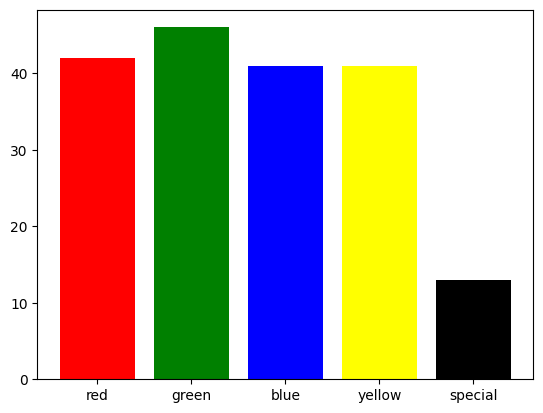

In [3]:
class Color(Enum):
    RED="red"
    GREEN="green"
    BLUE="blue"
    YELLOW="yellow"
    ALL="all"
    
allCardCount=0
cardCount={
Color.RED:0,Color.GREEN:0,Color.BLUE:0,Color.YELLOW:0,Color.ALL:0}

for key in deck:
    for color in Color:
        cardCount[color]+=deck[key][color.value]
        allCardCount+=deck[key][color.value]

cardCount

x=[]
for key in cardCount.keys():
    if key==color.ALL:
        x.append('special')
    else:
        x.append(key.value)
y=cardCount.values()
plt.bar(x=x,height=y,color=['red','green','blue','yellow','black'])
print(f"SUM: {allCardCount}")

MoveCounts of 1001 UNO games:
[1149, 813, 704, 1578, 861, 890, 283, 830, 661, 609, 673, 385, 419, 767, 567, 1013, 682, 680, 460, 1099, 447, 797, 190, 430, 580, 697, 985, 596, 529, 1090, 391, 932, 515, 620, 528, 513, 522, 453, 1046, 541, 543, 479, 412, 544, 921, 738, 524, 414, 254, 974, 836, 283, 761, 669, 332, 1326, 419, 732, 363, 1306, 445, 442, 363, 877, 449, 498, 487, 678, 1408, 1620, 327, 649, 857, 954, 603, 650, 516, 789, 248, 521, 894, 648, 243, 1517, 580, 730, 425, 931, 591, 303, 599, 323, 294, 958, 607, 905, 846, 383, 680, 272, 343, 264, 750, 243, 786, 356, 938, 826, 546, 492, 380, 473, 395, 836, 470, 416, 383, 706, 234, 1022, 609, 483, 438, 428, 562, 657, 631, 597, 599, 507, 463, 772, 737, 304, 465, 925, 763, 279, 918, 290, 293, 1208, 1577, 175, 485, 518, 189, 1455, 292, 622, 575, 336, 480, 986, 468, 603, 619, 707, 893, 928, 340, 539, 891, 800, 868, 1369, 752, 572, 419, 860, 512, 658, 855, 436, 783, 1277, 671, 681, 454, 583, 861, 1505, 568, 435, 874, 419, 471, 323, 380, 487, 6

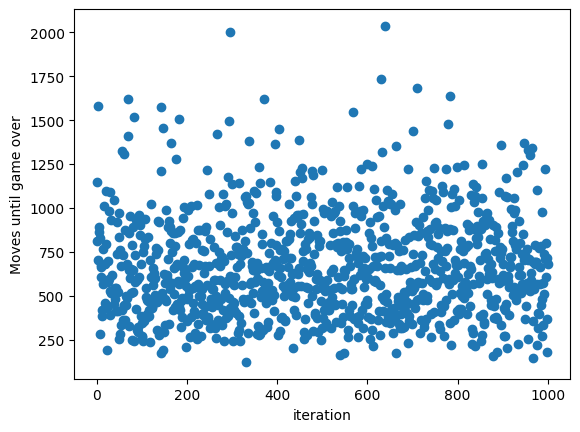

In [8]:
# house rule simulation

class CardName(Enum):
    ZERO=0
    ONE=1
    TWO=2
    THREE=3
    FOUR=4
    FIVE=5
    SIX=6
    SEVEN=7
    EIGHT=8
    NINE=9
    SKIP=10
    DRAW_2=11
    REVERSE=12
    WILD=13
    WILD_DRAW_4=14

class Card:
    def __init__(s, name:CardName,color:Color):
        s.name = name
        s.color=color
        
    @staticmethod
    def isWild(card)-> bool:
        if card.name==CardName.WILD or card.name==CardName.WILD_DRAW_4:
            return True
        else: 
            return False
        
    @staticmethod
    def jsonCardToCard(name:str,color:Color):
        cardName=None
        match name:
            case "0":
                cardName=CardName.ZERO
            case "1":
                cardName=CardName.ONE
            case "2":
                cardName=CardName.TWO
            case "3":
                cardName=CardName.THREE
            case "4":
                cardName=CardName.FOUR
            case "5":
                cardName=CardName.FIVE
            case "6":
                cardName=CardName.SIX
            case "7":
                cardName=CardName.SEVEN
            case "8":
                cardName=CardName.EIGHT
            case "9":
                cardName=CardName.NINE
            case "skip":
                cardName=CardName.SKIP
            case "draw2":
                cardName=CardName.DRAW_2
            case "reverse":
                cardName=CardName.REVERSE
            case "wild":
                cardName=CardName.WILD
            case "wild draw4":
                cardName=CardName.WILD_DRAW_4
            case _:
                raise ValueError(f"unknown JSON Card name: {name}") 
        return Card(cardName,color)

    def __str__(s):
        return f"{s.name} - {s.color}"
        

class Deck:
    notEnoughCardsError="not enough cards to draw"
    def __init__(s):
        s.cards=[]
        pass
    def addCardsFromJson(s,json):
        for key in json:
            for color in Color:
                for i in range(json[key][color.value]):
                    s.cards.append(Card.jsonCardToCard(key,color))
    def shuffle(s):
        random.shuffle(s.cards)
    def drawCards(s,n:int,stacker)->  List[Card]:
        if(n > len(s.cards)):
            s.cards.extend(stacker.getAndRemoveCardsExceptOfLast())
            s.shuffle()
        ret=[]
        for i in range(n):
            ret.append(s.cards.pop())
        return ret
    def getAndRemoveCardsExceptOfLast(s)-> List[Card]:
        ret=s.cards[:-1]
        s.cards=[s.cards[-1]]
        return ret
    def addCards(s,cards):
        s.cards.extend(cards)
    def lastCard(s) -> Card:
        return s.cards[-1]
    def __str__(s):
        ret=""
        for card in s.cards:
            ret+=str(card)
            ret+="\n"
        return ret

class Player:
    noCardToPlayError="there is no playable card to play"

    def __init__(s, name:str,cards:list[Card]):
        s.name = name
        s.wonAfterXMoves=-1
        s.cards=cards
    
    def playCard(s,stackerCard:Card)-> Card:
        bestCard=None
        if stackerCard.name==CardName.DRAW_2:
            for card in s.cards:
                if card.name==CardName.DRAW_2:
                    s.cards.remove(card) 
                    return card
        if not bestCard and stackerCard.name==CardName.DRAW_2:
            for card in s.cards:
                if card.name==CardName.WILD_DRAW_4:
                    s.cards.remove(card) 
                    return card
        if not bestCard and stackerCard.name==CardName.WILD_DRAW_4:
            for card in s.cards:
                if card.name==CardName.WILD_DRAW_4:
                    s.cards.remove(card) 
                    return card

        for card in s.cards:
            if card.name==stackerCard.name:
                bestCard=card
            if card.color==stackerCard.color or stackerCard.color==Color.ALL:
                bestCard=card
        if not bestCard:
            for card in s.cards:
                if Card.isWild(card):
                    bestCard=card
                    break
        if not bestCard:
            raise ValueError(Player.noCardToPlayError)
        else:
            s.cards.remove(bestCard) 
            if Card.isWild(bestCard):
                redCount=0
                blueCount=0
                greenCount=0
                yellowCount=0
                for card in s.cards:
                    match card.color:
                        case Color.RED:
                            redCount+=1
                        case Color.BLUE:
                            blueCount+=1
                        case Color.GREEN:
                            greenCount+=1
                        case Color.YELLOW:
                            yellowCount+=1
                        case _:
                            pass
                bestCard.color= Color.RED if (redCount>blueCount and redCount > greenCount and redCount>yellowCount)else  Color.BLUE if (blueCount>greenCount and greenCount>yellowCount) else Color.GREEN if (greenCount>yellowCount) else Color.YELLOW
            return bestCard
        
    def drawCards(s,stack:Deck,amount:int,stacker:Deck):
        s.cards.extend(stack.drawCards(amount,stacker))

    def isDone(s)->bool:
        return len(s.cards)<=0

    def __str__(s):
        if(s.isDone()):
            return f"{s.name} fin in {s.wonAfterXMoves} moves"
            
        else:
            return f"{s.name} - {len(s.cards)}"
           
    
class Direction(Enum):
    CLOCK_WISE=0,
    COUNTER_CLOCK_WISE=1

class Game:
    def __init__(s,deck,playerCount,startCardCount):
        s.moveCount=0

        s.direction=Direction.CLOCK_WISE
        s.cardsToDraw=0

        s.stack=Deck()
        s.stack.addCardsFromJson(deck)
        s.stack.shuffle()
        
        s.stacker=Deck()
        s.stacker.addCards(s.stack.drawCards(1,s.stacker))
        s.history=[s.stacker.lastCard()]

        s.players: List[Player]=list()
        s.currentPlayer=0
        for i in range(playerCount):
            s.players.append(Player(f"player {i}",s.stack.drawCards(startCardCount,s.stacker)))
    
    def makeMove(s):
        s.moveCount+=1
        player=s.players[s.currentPlayer]

        lastCard=s.stacker.lastCard()
        moveCard=None

        hasToDraw=False
        while(not moveCard):
            try:
                moveCard=player.playCard(lastCard)
                
            except:
                player.drawCards(s.stack,1,s.stacker)
                s.history.append(f"{player.name} had no card to play and draw one")
                s.cardsToDraw=max(0,s.cardsToDraw-1)
                hasToDraw=True

        s.stacker.addCards([moveCard]) 
        s.history.append(f"{player.name} - {moveCard}")

        if not hasToDraw and  lastCard.name==CardName.DRAW_2 and moveCard.name==CardName.DRAW_2:
            s.cardsToDraw+=2
        elif not hasToDraw and lastCard.name==CardName.DRAW_2 and moveCard.name==CardName.WILD_DRAW_4:
            s.cardsToDraw+=4
        elif not hasToDraw and lastCard.name==CardName.WILD_DRAW_4 and moveCard==CardName.WILD_DRAW_4:
            s.cardsToDraw+=4
        else:
            player.drawCards(s.stack,s.cardsToDraw,s.stacker)
            
            if(moveCard.name==CardName.DRAW_2):
                s.cardsToDraw=2
            elif(moveCard.name==CardName.WILD_DRAW_4):
                s.cardsToDraw=4
            else:
                s.cardsToDraw=0
        
        if player.isDone():
            player.wonAfterXMoves=s.moveCount
            doneMessage=f"{player.name} finished on move {s.moveCount}"
            s.history.append(doneMessage)
        

        

        if moveCard.name==CardName.REVERSE:
            s.direction=s.direction==Direction.CLOCK_WISE if Direction.COUNTER_CLOCK_WISE else Direction.CLOCK_WISE
        
        playerSteps=0
        while(True):
            nextPlayer=s.currentPlayer
            if s.direction==Direction.CLOCK_WISE:
                nextPlayer+=1
            else:
                nextPlayer-=1
            
            s.currentPlayer=nextPlayer%len(s.players)
            

            if not s.players[s.currentPlayer].isDone():
                playerSteps+=1
                if moveCard.name==CardName.SKIP:
                    if playerSteps>=2:
                        break
                else:
                    break

        

    def __str__(s):
        ret=f"playerCount: {len(s.players)}\n"
        ret+=f"stackCount: {len(s.stack.cards)}\n"
        ret+=f"stackerCount: {len(s.stacker.cards)}\n"
        ret+=f"moveCount: {s.moveCount}\n"
        ret+=f"cardsToDraw: {s.cardsToDraw}\n"
        ret+=f"currentPlayer: {s.currentPlayer}\n"
        for player in s.players:
            ret+=str(player)+"\n"
        ret+=f"currentOpenCard: {s.stacker.lastCard()}\n"
        ret+="\nhistory:\n"
        for element in s.history[len(s.history)-3:]:
             ret+=str(element)+"\n"
        return ret



Moves=[]
iterations=1001
for i in range(iterations):
    playerCount=8
    game=Game(deck,playerCount,7)

    while(True):
        finCount=0
        for player in game.players:
            if  player.isDone():
                finCount+=1
        if finCount>=playerCount-1:
            break

        game.makeMove()
    Moves.append(game.moveCount)

print(f"MoveCounts of {iterations} UNO games:")
print(Moves)
print(f"Mean:   {numpy.mean(Moves)}")
print(f"Median: {numpy.median(Moves)}")
print(f"Max:    {numpy.max(Moves)}")
print(f"Min:    {numpy.min(Moves)}")

plt.scatter(x=range(len(Moves)),y=Moves)
plt.xlabel("iteration")
plt.ylabel("Moves until game over")
print("",end="")